In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

import linearmodels as lm
from linearmodels import PanelOLS
from linearmodels.panel import compare

import sklearn as sk
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [132]:
# Importing the dataset
df = pd.read_excel('ticker_list_final.xlsx', sheet_name='pool_data')
df['Scope_1_2Location'] = df['Scope_1'] + df['Scope_2_Location']
df['Scope_1_2Market'] = df['Scope_1'] + df['Scope_2_Market']

In [133]:
# Data Cleaning
df['Sector'].replace('Industrails', 'Industrials', inplace=True)
df['Sector'].value_counts()

Industrials               104
Consumer Discretionary    100
Information Technology     60
Consumer Staples           56
Materials                  52
Health Care                44
Utilities                  36
Communication Services     28
Technology                  4
Real Estate                 4
Consumer Cyclicals          4
Name: Sector, dtype: int64

In [134]:
# Proportion of Sector Representation
df_sr = df.groupby(['Sector']).size().reset_index(name='counts')
df_sr['proportion'] = df_sr['counts'] / df_sr['counts'].sum()
df_sr = df_sr.sort_values(by=['proportion'], ascending=False)
df_sr.rename(columns={'proportion': 'Proportion', 'counts': 'Counts'}, inplace=True)
df_sr['Proportion'] = df_sr['Proportion'].map('{:,.2%}'.format)
df_sr['Counts'] = np.divide(df_sr['Counts'], 4)
df_sr

,Sector,Counts,Proportion
5,Industrials,26.00,21.14%
2,Consumer Discretionary,25.00,20.33%
6,Information Technology,15.00,12.20%
3,Consumer Staples,14.00,11.38%
7,Materials,13.00,10.57%
4,Health Care,11.00,8.94%
10,Utilities,9.00,7.32%
0,Communication Services,7.00,5.69%
1,Consumer Cyclicals,1.00,0.81%
8,Real Estate,1.00,0.81%


In [135]:
# Convert Proportions to LaTex
print(df_sr.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
                Sector &  Counts & Proportion \\
\midrule
           Industrials &   26.00 &     21.14\% \\
Consumer Discretionary &   25.00 &     20.33\% \\
Information Technology &   15.00 &     12.20\% \\
      Consumer Staples &   14.00 &     11.38\% \\
             Materials &   13.00 &     10.57\% \\
           Health Care &   11.00 &      8.94\% \\
             Utilities &    9.00 &      7.32\% \\
Communication Services &    7.00 &      5.69\% \\
    Consumer Cyclicals &    1.00 &      0.81\% \\
           Real Estate &    1.00 &      0.81\% \\
            Technology &    1.00 &      0.81\% \\
\bottomrule
\end{tabular}



In [136]:
# Separating the data into two dataframes
x_vars = ['Sector', 'const', 'Asset Turnover', 'Current Ratio', 'EBITDA Margin', 'ESG Score', 'Quick Ratio']
y_vars = ['Scope_1', 'Scope_2_Location', 'Scope_2_Market', 'Scope_1_2Location', 'Scope_1_2Market']
df_x = df.copy()
df_x = df_x.drop(y_vars, axis=1)
# df_x = df_x.drop(['Sector'], axis=1)
df_y = df[y_vars]

# Create Regression Inputs
pooledOLS_X = sm.add_constant(df_x) # B0 + B1X1 ... BnXn

# Drop Sector Column
pooledOLS_X = pooledOLS_X[x_vars]
pooledOLS_X = pooledOLS_X.drop(['Sector'], axis=1)

# Dependent Variables
pooledOLS_Y = df_y

pooledOLS_X


,const,Asset Turnover,Current Ratio,EBITDA Margin,ESG Score,Quick Ratio
0,1.00,0.80,2.61,27.46,27.35,2.54
1,1.00,0.87,2.10,23.89,38.61,2.10
2,1.00,1.43,2.44,21.00,50.55,2.44
3,1.00,1.39,1.29,21.79,59.32,1.29
4,1.00,1.55,1.09,6.90,92.72,0.76
...,...,...,...,...,...,...
487,1.00,1.01,1.03,11.71,90.13,1.03
488,1.00,1.94,1.76,15.06,66.84,1.47
489,1.00,1.89,1.56,15.63,72.44,1.31
490,1.00,1.52,1.30,15.43,85.91,1.08


In [137]:
# Summary Statistics of Explanatory Variables
expl = pd.concat([pooledOLS_X, pooledOLS_Y], axis=1)
expl
expl.drop(['const'], axis=1, inplace=True)

def sum_stats(s_returns):
    mu = s_returns.mean()
    med = s_returns.median()
    std = s_returns.std()
    skew = s_returns.skew()
    kurt = s_returns.kurtosis() # Excess Kurtosis (Fisher's Kurtosis)
    sumstats = [mu, med, std, skew, kurt]
    df_sumstats = pd.DataFrame(sumstats)
    index = pd.Index(['Mean', 'Median', 'Std. Dev.', 'Skewness', 'Kurtosis'])
    df_sumstats = df_sumstats.set_index(index)
    return df_sumstats

q2_out = sum_stats(expl)
q2_out = q2_out.transpose()
q2_out = q2_out.round(2)
q2_out.reset_index(drop=False, inplace=True)
q2_out.rename(columns={'index': 'Variables'}, inplace=True)
q2_out['Variables'].replace('_', ' ', regex=True, inplace=True)
q2_out['Variables'].replace('2L', '+ 2 L', regex=True, inplace=True)
q2_out['Variables'].replace('2M', '+ 2 M', regex=True, inplace=True)

print("The Summary Statistics for the Explanatory Variables are:\n")
print(q2_out.to_latex(index=False))

The Summary Statistics for the Explanatory Variables are:

\begin{tabular}{lrrrrr}
\toprule
           Variables &         Mean &    Median &     Std. Dev. &  Skewness &  Kurtosis \\
\midrule
      Asset Turnover &         0.94 &      0.82 &          0.57 &      1.51 &      3.72 \\
       Current Ratio &         1.40 &      1.25 &          0.72 &      2.78 &     10.68 \\
       EBITDA Margin &        16.09 &     13.89 &         14.55 &     -1.27 &      8.87 \\
           ESG Score & 114278521.67 &     70.33 & 1170065709.56 &     11.10 &    123.48 \\
         Quick Ratio &         1.10 &      0.95 &          0.67 &      3.29 &     14.66 \\
             Scope 1 &   2908207.44 & 114720.00 &   13007560.38 &      7.02 &     52.06 \\
    Scope 2 Location &    472194.31 & 155188.00 &     876821.53 &      5.06 &     38.91 \\
      Scope 2 Market &    385082.98 &  88187.00 &     803380.54 &      4.12 &     20.13 \\
Scope 1 + 2 Location &   3380401.75 & 385123.00 &   13267950.62 &      6.87 &   

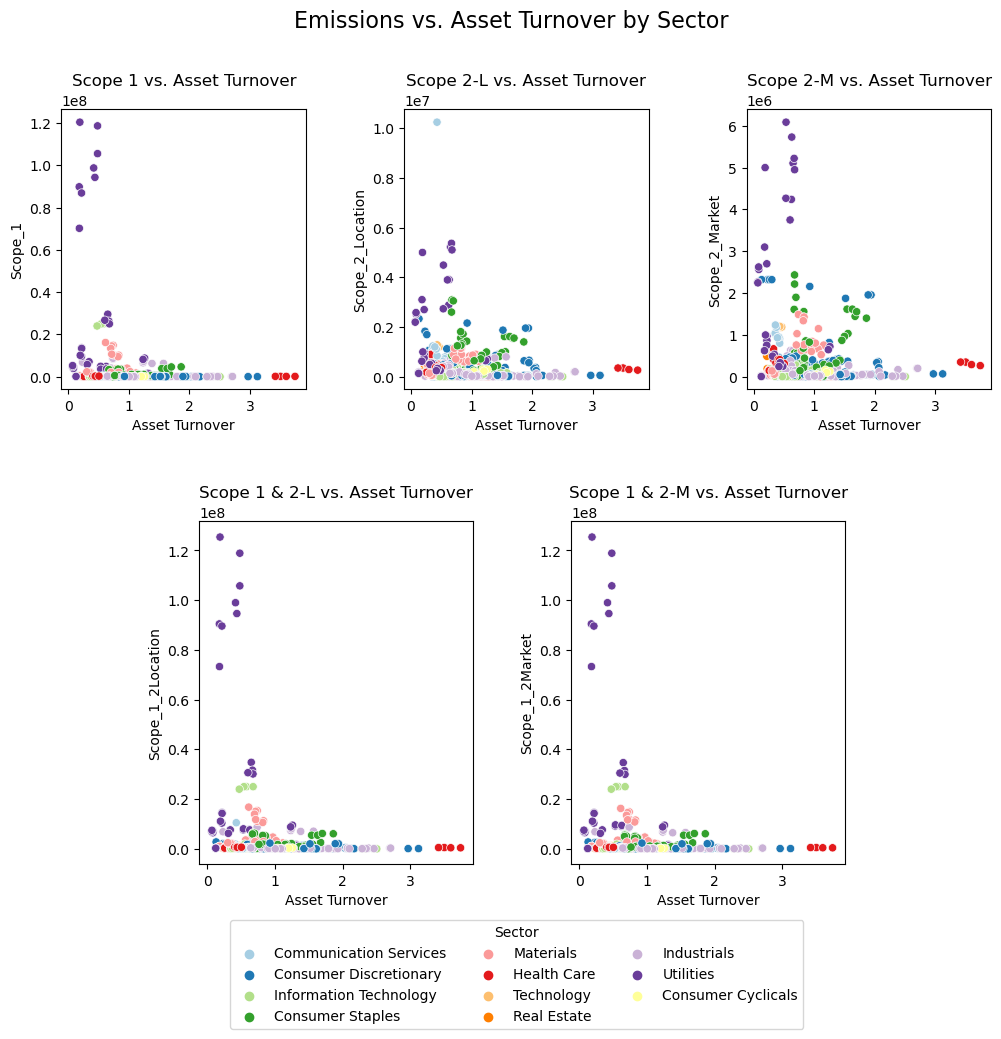

In [138]:
# Data Visualization - Scatter Plot to Examine Relationships

# Create Subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
sns.set_palette("Paired")
sns.scatterplot(x='Asset Turnover', y='Scope_1', data=df, hue='Sector', ax=axes[0, 0], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_2_Location', data=df, hue='Sector', ax=axes[0, 1], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_2_Market', data=df, hue='Sector', ax=axes[0, 2], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_1_2Location', data=df, hue='Sector', ax=axes[1, 0], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_1_2Market', data=df, hue='Sector', ax=axes[1, 1])

# Alter Legend
sns.move_legend(axes[1, 1], "lower center", bbox_to_anchor=(-0.2, -0.5), ncol=3)

# Set Titles
axes[0, 0].set_title('Scope 1 vs. Asset Turnover')
axes[0, 1].set_title('Scope 2-L vs. Asset Turnover')
axes[0, 2].set_title('Scope 2-M vs. Asset Turnover')
axes[1, 0].set_title('Scope 1 & 2-L vs. Asset Turnover')
axes[1, 1].set_title('Scope 1 & 2-M vs. Asset Turnover')
fig.suptitle('Emissions vs. Asset Turnover by Sector', fontsize=16)

# Adjust Spacing
plt.subplots_adjust(wspace=0.4, hspace=0.75)

# Alter Positioning of Subplots
axes[1,2].set_visible(False)
axes[1,0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1,1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

In [139]:
# Create Dummy Variables for Utilities Sector due to High Emissions Outliers
df['Utilities'] = np.where(df['Sector'] == 'Utilities', 1, 0)

# Add Dummy Variable to Regression Inputs
pooledOLS_X['Utilities'] = df['Utilities']

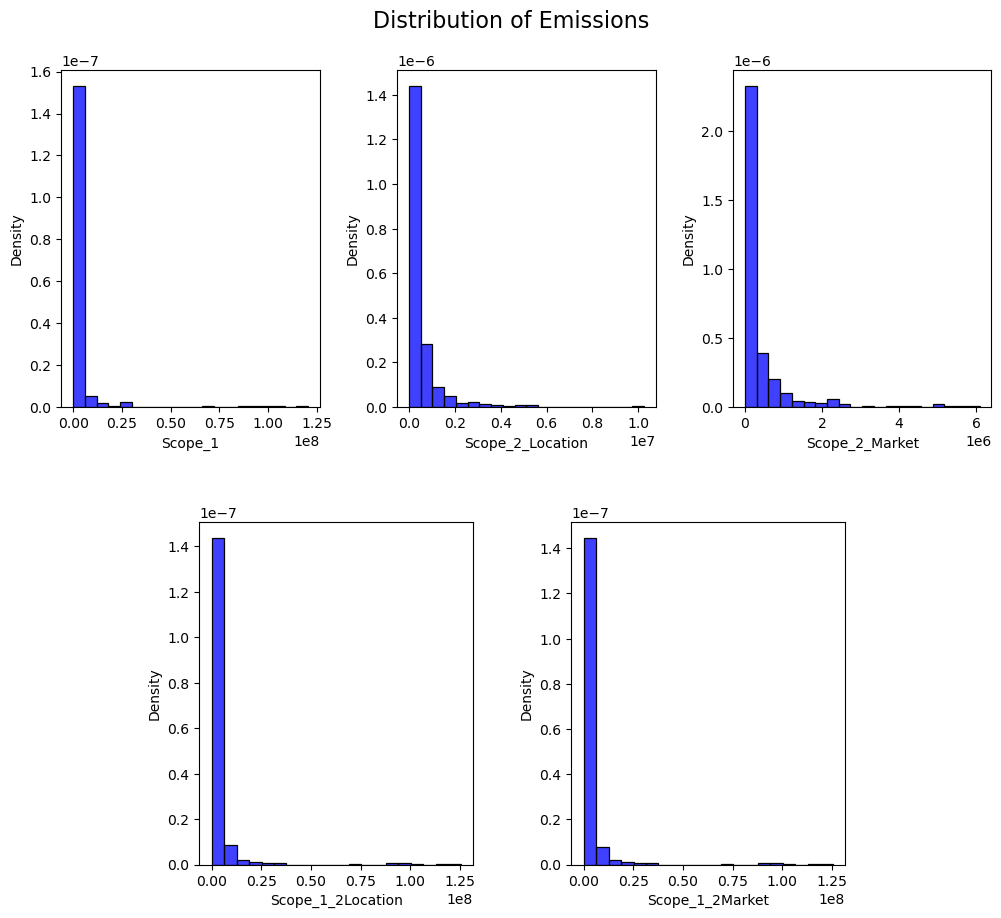

In [140]:
# Data Visualisation - Histograms to Examine Distribution of Emissions
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
sns.histplot(x='Scope_1', data=df, ax=axes[0, 0], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_2_Location', data=df, ax=axes[0, 1], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_2_Market', data=df, ax=axes[0, 2], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_1_2Location', data=df, ax=axes[1, 0], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_1_2Market', data=df, ax=axes[1, 1], stat='density', bins=20, color='blue')
plt.suptitle('Distribution of Emissions', fontsize=16)

# Adjust Spacing
plt.subplots_adjust(wspace=0.3, hspace=0.4)
fig.subplots_adjust(top=0.92)

# Alter Positioning of Subplots
axes[1,2].set_visible(False)
axes[1,0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1,1].set_position([0.55, 0.125, 0.228, 0.343])


plt.show()

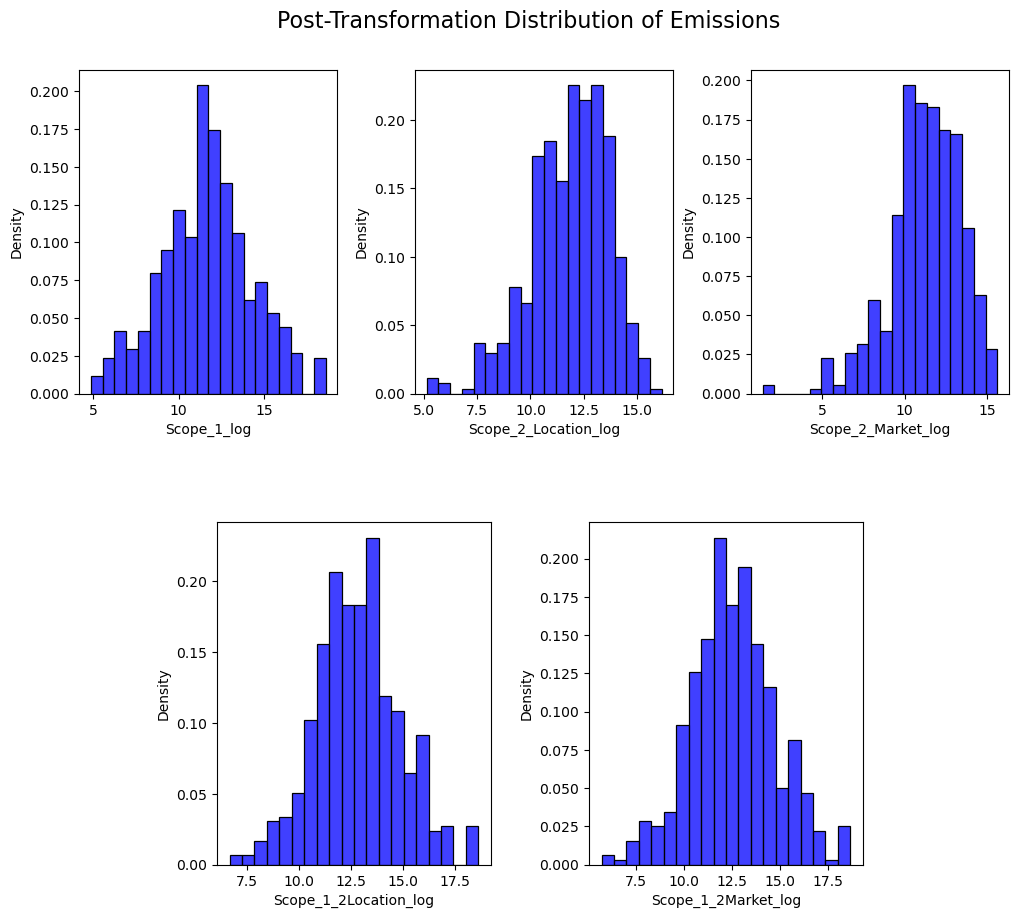

In [141]:
# Data Transformation - Log Transformation
pooledOLS_Y_log = pd.DataFrame()
pooledOLS_Y_log['Scope_1_log'] = np.log(df.loc[:, 'Scope_1'])
pooledOLS_Y_log['Scope_2_Location_log'] = np.log(df.loc[:, 'Scope_2_Location'])
pooledOLS_Y_log['Scope_2_Market_log'] = np.log(df.loc[:, 'Scope_2_Market'])
pooledOLS_Y_log['Scope_1_2Location_log'] = np.log(df.loc[:, 'Scope_1_2Location'])
pooledOLS_Y_log['Scope_1_2Market_log'] = np.log(df.loc[:, 'Scope_1_2Market'])

# Data Visualisation - Histograms to Examine Distribution of Emissions
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
sns.histplot(x='Scope_1_log', data=pooledOLS_Y_log, ax=axes[0, 0], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_2_Location_log', data=pooledOLS_Y_log, ax=axes[0, 1], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_2_Market_log', data=pooledOLS_Y_log, ax=axes[0, 2], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_1_2Location_log', data=pooledOLS_Y_log, ax=axes[1, 0], stat='density', bins=20, color='blue')
sns.histplot(x='Scope_1_2Market_log', data=pooledOLS_Y_log, ax=axes[1, 1], stat='density', bins=20, color='blue')
plt.suptitle('Post-Transformation Distribution of Emissions', fontsize=16)

# Adjust Spacing
plt.subplots_adjust(wspace=0.3, hspace=0.5)
fig.subplots_adjust(top=0.92)

# Alter Positioning of Subplots
axes[1,2].set_visible(False)
axes[1,0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1,1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

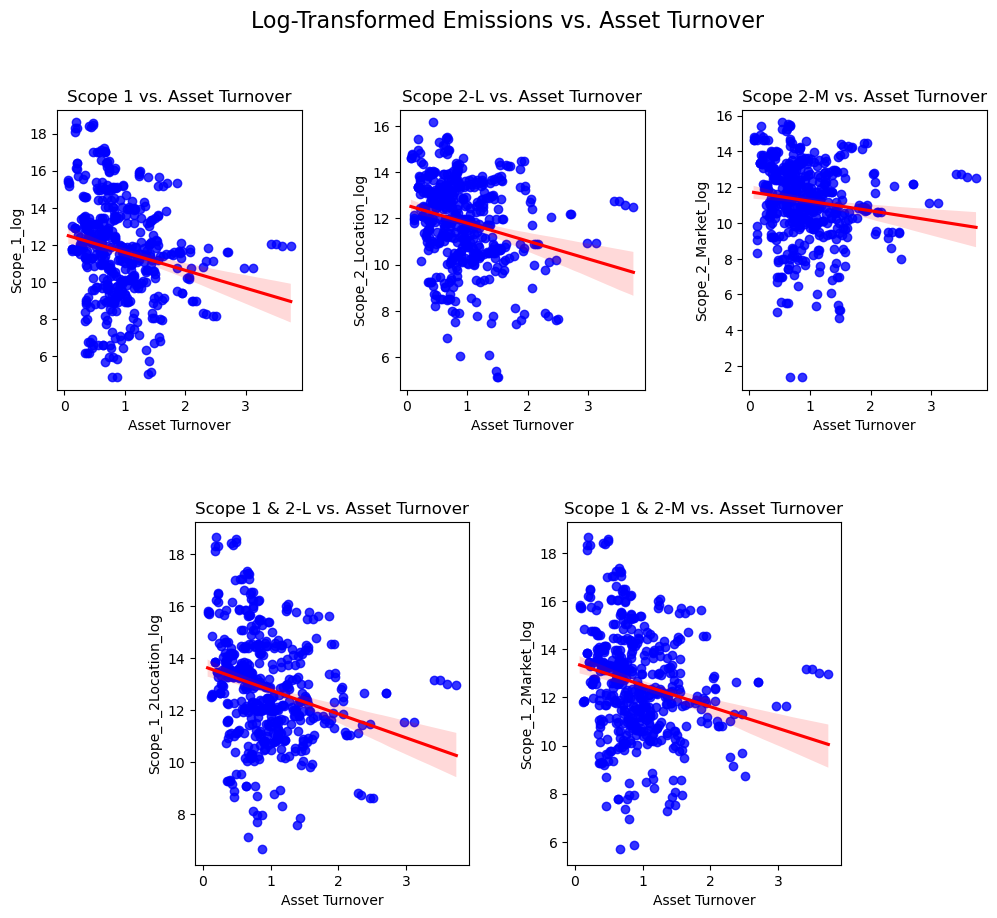

In [142]:
# Data Visualization - Regression Plot to Examine Relationships
plot_data = pooledOLS_Y_log.copy()
plot_data['Asset Turnover'] = df['Asset Turnover']
plot_data['Sector'] = df['Sector']

# Create Subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
sns.set_palette("Paired")
sns.regplot(x='Asset Turnover', y='Scope_1_log', data=plot_data, ax=axes[0, 0], scatter=True, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.regplot(x='Asset Turnover', y='Scope_2_Location_log', data=plot_data, ax=axes[0, 1], scatter=True, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.regplot(x='Asset Turnover', y='Scope_2_Market_log', data=plot_data, ax=axes[0, 2], scatter=True, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.regplot(x='Asset Turnover', y='Scope_1_2Location_log', data=plot_data, ax=axes[1, 0], scatter=True, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.regplot(x='Asset Turnover', y='Scope_1_2Market_log', data=plot_data, ax=axes[1, 1], scatter=True, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

# Alter Legend
# sns.move_legend(axes[1, 1], "lower center", bbox_to_anchor=(-0.2, -0.5), ncol=3)

# Set Titles
axes[0, 0].set_title('Scope 1 vs. Asset Turnover')
axes[0, 1].set_title('Scope 2-L vs. Asset Turnover')
axes[0, 2].set_title('Scope 2-M vs. Asset Turnover')
axes[1, 0].set_title('Scope 1 & 2-L vs. Asset Turnover')
axes[1, 1].set_title('Scope 1 & 2-M vs. Asset Turnover')
fig.suptitle('Log-Transformed Emissions vs. Asset Turnover', fontsize=16)

# Adjust Spacing
plt.subplots_adjust(wspace=0.4, hspace=0.75)

# Alter Positioning of Subplots
axes[1,2].set_visible(False)
axes[1,0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1,1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

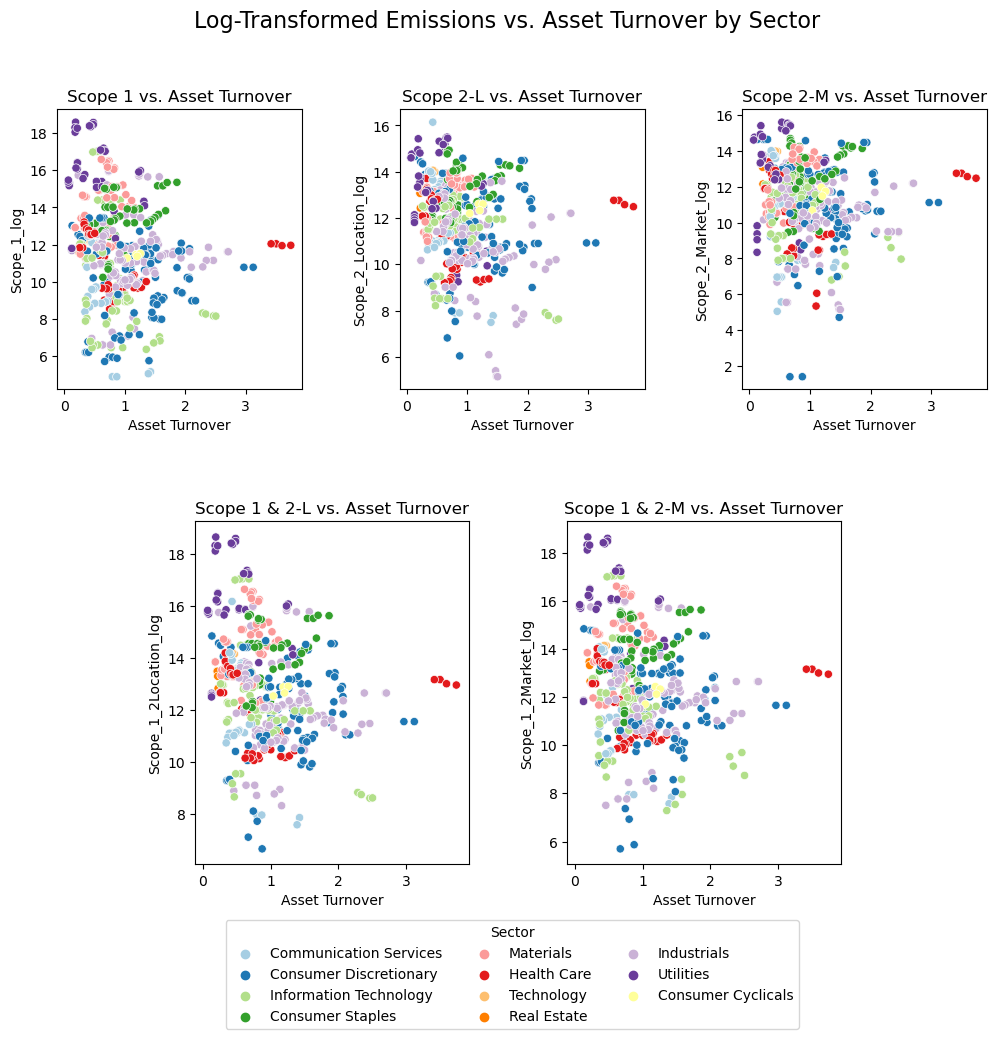

In [143]:
# Data Visualization - Scatter Plot to Examine Relationships
plot_data = pooledOLS_Y_log.copy()
plot_data['Asset Turnover'] = df['Asset Turnover']
plot_data['Sector'] = df['Sector']

# Create Subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
sns.set_palette("Paired")
sns.scatterplot(x='Asset Turnover', y='Scope_1_log', data=plot_data, hue='Sector', ax=axes[0, 0], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_2_Location_log', data=plot_data, hue='Sector', ax=axes[0, 1], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_2_Market_log', data=plot_data, hue='Sector', ax=axes[0, 2], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_1_2Location_log', data=plot_data, hue='Sector', ax=axes[1, 0], legend=False)
sns.scatterplot(x='Asset Turnover', y='Scope_1_2Market_log', data=plot_data, hue='Sector', ax=axes[1, 1])

# Alter Legend
sns.move_legend(axes[1, 1], "lower center", bbox_to_anchor=(-0.2, -0.5), ncol=3)

# Set Titles
axes[0, 0].set_title('Scope 1 vs. Asset Turnover')
axes[0, 1].set_title('Scope 2-L vs. Asset Turnover')
axes[0, 2].set_title('Scope 2-M vs. Asset Turnover')
axes[1, 0].set_title('Scope 1 & 2-L vs. Asset Turnover')
axes[1, 1].set_title('Scope 1 & 2-M vs. Asset Turnover')
fig.suptitle('Log-Transformed Emissions vs. Asset Turnover by Sector', fontsize=16)

# Adjust Spacing
plt.subplots_adjust(wspace=0.4, hspace=0.75)

# Alter Positioning of Subplots
axes[1,2].set_visible(False)
axes[1,0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1,1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

In [144]:
# Model 1: Pooled OLS - Scope 1
pooledOLS = sm.OLS(endog=pooledOLS_Y_log['Scope_1_log'], exog=pooledOLS_X)
pooledOLS_model1 = pooledOLS.fit()
results = pooledOLS_model1.summary()
results_latex = results.as_latex()
print(results)


                            OLS Regression Results                            
Dep. Variable:            Scope_1_log   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     29.90
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           1.57e-30
Time:                        23:53:25   Log-Likelihood:                -1102.2
No. Observations:                 492   AIC:                             2218.
Df Residuals:                     485   BIC:                             2248.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.3392      0.354     37.

In [145]:
# Residual Diagnostics - White Test
# Null Hypothesis: Homoscedasticity
# Alternative Hypothesis: Heteroscedasticity
# If p-value < 0.05, reject null hypothesis
names = ['Lagrange multiplier statistic', 'LM p-value', 'f-value', 'f-stat p-value']
test = het_white(pooledOLS_model1.resid, pooledOLS_model1.model.exog)
white_t = dict(zip(names, test))
white_df = pd.DataFrame(white_t, index=['White Test'])

if white_t['LM p-value'] < 0.05:
    print('White Test: Reject Null Hypothesis, Heteroscedasticity')
else:
    print('White Test: Fail to Reject Null Hypothesis, Homoscedasticity')

print((white_df.round(1)).to_latex())

White Test: Fail to Reject Null Hypothesis, Homoscedasticity
\begin{tabular}{lrrrr}
\toprule
{} &  Lagrange multiplier statistic &  LM p-value &  f-value &  f-stat p-value \\
\midrule
White Test &                        -209.60 &        1.00 &   -29.00 &            1.00 \\
\bottomrule
\end{tabular}



In [146]:
# Convert Model 1 Results to Latex
print(results_latex)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &  Scope\_1\_log   & \textbf{  R-squared:         } &     0.270   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.261   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     29.90   \\
\textbf{Date:}             & Thu, 22 Jun 2023 & \textbf{  Prob (F-statistic):} &  1.57e-30   \\
\textbf{Time:}             &     23:53:25     & \textbf{  Log-Likelihood:    } &   -1102.2   \\
\textbf{No. Observations:} &         492      & \textbf{  AIC:               } &     2218.   \\
\textbf{Df Residuals:}     &         485      & \textbf{  BIC:               } &     2248.   \\
\textbf{Df Model:}         &           6      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                        & \textbf{coef}

In [147]:
# Model 2: Pooled OLS - Scope 2 Location
pooledOLS = sm.OLS(endog=pooledOLS_Y_log['Scope_2_Location_log'], exog=pooledOLS_X)
pooledOLS_model2 = pooledOLS.fit()
results = pooledOLS_model2.summary()
results_latex = results.as_latex()
print(results)


                             OLS Regression Results                             
Dep. Variable:     Scope_2_Location_log   R-squared:                       0.203
Model:                              OLS   Adj. R-squared:                  0.193
Method:                   Least Squares   F-statistic:                     20.61
Date:                  Thu, 22 Jun 2023   Prob (F-statistic):           1.55e-21
Time:                          23:53:25   Log-Likelihood:                -942.35
No. Observations:                   492   AIC:                             1899.
Df Residuals:                       485   BIC:                             1928.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.058

In [148]:
# Residual Diagnostics - White's Test
# Null Hypothesis: Homoscedasticity
# Alternative Hypothesis: Heteroscedasticity
# If p-value < 0.05, reject null hypothesis
names = ['Lagrange multiplier statistic', 'LM p-value', 'f-value', 'f-stat p-value']
test = het_white(pooledOLS_model2.resid, pooledOLS_model2.model.exog)
white_t = dict(zip(names, test))
white_df = pd.DataFrame(white_t, index=['White Test'])
white_df.round(1)


if white_t['LM p-value'] < 0.05:
    print('White Test: Reject Null Hypothesis, Heteroscedasticity')
else:
    print('White Test: Fail to Reject Null Hypothesis, Homoscedasticity')

print((white_df.round(1)).to_latex())

White Test: Fail to Reject Null Hypothesis, Homoscedasticity
\begin{tabular}{lrrrr}
\toprule
{} &  Lagrange multiplier statistic &  LM p-value &  f-value &  f-stat p-value \\
\midrule
White Test &                        -186.50 &        1.00 &   -26.70 &            1.00 \\
\bottomrule
\end{tabular}



In [149]:
# Convert Model 2 Results to Latex
print(results_latex)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & Scope\_2\_Location\_log & \textbf{  R-squared:         } &     0.203   \\
\textbf{Model:}            &           OLS           & \textbf{  Adj. R-squared:    } &     0.193   \\
\textbf{Method:}           &      Least Squares      & \textbf{  F-statistic:       } &     20.61   \\
\textbf{Date:}             &     Thu, 22 Jun 2023    & \textbf{  Prob (F-statistic):} &  1.55e-21   \\
\textbf{Time:}             &         23:53:25        & \textbf{  Log-Likelihood:    } &   -942.35   \\
\textbf{No. Observations:} &             492         & \textbf{  AIC:               } &     1899.   \\
\textbf{Df Residuals:}     &             485         & \textbf{  BIC:               } &     1928.   \\
\textbf{Df Model:}         &               6         & \textbf{                     } &             \\
\textbf{Covariance Type:}  &        nonrobust        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\

In [150]:
# Model 3: Pooled OLS - Scope 2 Market
pooledOLS = sm.OLS(endog=pooledOLS_Y_log['Scope_2_Market_log'], exog=pooledOLS_X)
pooledOLS_model3 = pooledOLS.fit()
results = pooledOLS_model3.summary()
results_latex = results.as_latex()
print(results)


                            OLS Regression Results                            
Dep. Variable:     Scope_2_Market_log   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     14.46
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           3.35e-15
Time:                        23:53:25   Log-Likelihood:                -1040.3
No. Observations:                 492   AIC:                             2095.
Df Residuals:                     485   BIC:                             2124.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.5910      0.312     40.

In [151]:
# Residual Diagnostics - White's Test
# Null Hypothesis: Homoscedasticity
# Alternative Hypothesis: Heteroscedasticity
# If p-value < 0.05, reject null hypothesis
names = ['Lagrange multiplier statistic', 'LM p-value', 'f-value', 'f-stat p-value']
test = het_white(pooledOLS_model3.resid, pooledOLS_model3.model.exog)
white_t = dict(zip(names, test))
white_df = pd.DataFrame(white_t, index=['White Test'])
white_df.round(1)


if white_t['LM p-value'] < 0.05:
    print('White Test: Reject Null Hypothesis, Heteroscedasticity')
else:
    print('White Test: Fail to Reject Null Hypothesis, Homoscedasticity')

print((white_df.round(1)).to_latex())

White Test: Fail to Reject Null Hypothesis, Homoscedasticity
\begin{tabular}{lrrrr}
\toprule
{} &  Lagrange multiplier statistic &  LM p-value &  f-value &  f-stat p-value \\
\midrule
White Test &                        -181.20 &        1.00 &   -26.20 &            1.00 \\
\bottomrule
\end{tabular}



In [152]:
# Convert Model 3 Results to Latex
print(results_latex)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & Scope\_2\_Market\_log & \textbf{  R-squared:         } &     0.152   \\
\textbf{Model:}            &          OLS          & \textbf{  Adj. R-squared:    } &     0.141   \\
\textbf{Method:}           &     Least Squares     & \textbf{  F-statistic:       } &     14.46   \\
\textbf{Date:}             &    Thu, 22 Jun 2023   & \textbf{  Prob (F-statistic):} &  3.35e-15   \\
\textbf{Time:}             &        23:53:25       & \textbf{  Log-Likelihood:    } &   -1040.3   \\
\textbf{No. Observations:} &            492        & \textbf{  AIC:               } &     2095.   \\
\textbf{Df Residuals:}     &            485        & \textbf{  BIC:               } &     2124.   \\
\textbf{Df Model:}         &              6        & \textbf{                     } &             \\
\textbf{Covariance Type:}  &       nonrobust       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcc

In [153]:
# Model 4: Pooled OLS - Scope 1 + 2 Location
pooledOLS = sm.OLS(endog=pooledOLS_Y_log['Scope_1_2Location_log'], exog=pooledOLS_X)
pooledOLS_model4 = pooledOLS.fit()
results = pooledOLS_model4.summary()
results_latex = results.as_latex()
print(results)


                              OLS Regression Results                             
Dep. Variable:     Scope_1_2Location_log   R-squared:                       0.276
Model:                               OLS   Adj. R-squared:                  0.267
Method:                    Least Squares   F-statistic:                     30.75
Date:                   Thu, 22 Jun 2023   Prob (F-statistic):           2.60e-31
Time:                           23:53:25   Log-Likelihood:                -973.41
No. Observations:                    492   AIC:                             1961.
Df Residuals:                        485   BIC:                             1990.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [154]:
# Residual Diagnostics - White's Test
# Null Hypothesis: Homoscedasticity
# Alternative Hypothesis: Heteroscedasticity
# If p-value < 0.05, reject null hypothesis
names = ['Lagrange multiplier statistic', 'LM p-value', 'f-value', 'f-stat p-value']
test = het_white(pooledOLS_model4.resid, pooledOLS_model4.model.exog)
white_t = dict(zip(names, test))
white_df = pd.DataFrame(white_t, index=['White Test'])
white_df.round(1)


if white_t['LM p-value'] < 0.05:
    print('White Test: Reject Null Hypothesis, Heteroscedasticity')
else:
    print('White Test: Fail to Reject Null Hypothesis, Homoscedasticity')

print((white_df.round(1)).to_latex())

White Test: Fail to Reject Null Hypothesis, Homoscedasticity
\begin{tabular}{lrrrr}
\toprule
{} &  Lagrange multiplier statistic &  LM p-value &  f-value &  f-stat p-value \\
\midrule
White Test &                        -228.90 &        1.00 &   -30.90 &            1.00 \\
\bottomrule
\end{tabular}



In [155]:
# Convert Model 4 Results to Latex
print(results_latex)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & Scope\_1\_2Location\_log & \textbf{  R-squared:         } &     0.276   \\
\textbf{Model:}            &           OLS            & \textbf{  Adj. R-squared:    } &     0.267   \\
\textbf{Method:}           &      Least Squares       & \textbf{  F-statistic:       } &     30.75   \\
\textbf{Date:}             &     Thu, 22 Jun 2023     & \textbf{  Prob (F-statistic):} &  2.60e-31   \\
\textbf{Time:}             &         23:53:25         & \textbf{  Log-Likelihood:    } &   -973.41   \\
\textbf{No. Observations:} &             492          & \textbf{  AIC:               } &     1961.   \\
\textbf{Df Residuals:}     &             485          & \textbf{  BIC:               } &     1990.   \\
\textbf{Df Model:}         &               6          & \textbf{                     } &             \\
\textbf{Covariance Type:}  &        nonrobust         & \textbf{                     } &             \\
\bottomrule
\end{t

In [156]:
# Model 5: Pooled OLS - Scope 1 + 2 Market
pooledOLS = sm.OLS(endog=pooledOLS_Y_log['Scope_1_2Market_log'], exog=pooledOLS_X)
pooledOLS_model5 = pooledOLS.fit()
results = pooledOLS_model5.summary()
results_latex = results.as_latex()
print(results)


                             OLS Regression Results                            
Dep. Variable:     Scope_1_2Market_log   R-squared:                       0.263
Model:                             OLS   Adj. R-squared:                  0.254
Method:                  Least Squares   F-statistic:                     28.91
Date:                 Thu, 22 Jun 2023   Prob (F-statistic):           1.32e-29
Time:                         23:53:25   Log-Likelihood:                -1013.6
No. Observations:                  492   AIC:                             2041.
Df Residuals:                      485   BIC:                             2071.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.0582      0.2

In [157]:
# Residual Diagnostics - White's Test
# Null Hypothesis: Homoscedasticity
# Alternative Hypothesis: Heteroscedasticity
# If p-value < 0.05, reject null hypothesis
names = ['Lagrange multiplier statistic', 'LM p-value', 'f-value', 'f-stat p-value']
test = het_white(pooledOLS_model5.resid, pooledOLS_model5.model.exog)
white_t = dict(zip(names, test))
white_df = pd.DataFrame(white_t, index=['White Test'])
white_df.round(1)


if white_t['LM p-value'] < 0.05:
    print('White Test: Reject Null Hypothesis, Heteroscedasticity')
else:
    print('White Test: Fail to Reject Null Hypothesis, Homoscedasticity')

print((white_df.round(1)).to_latex())

White Test: Fail to Reject Null Hypothesis, Homoscedasticity
\begin{tabular}{lrrrr}
\toprule
{} &  Lagrange multiplier statistic &  LM p-value &  f-value &  f-stat p-value \\
\midrule
White Test &                        -234.10 &        1.00 &   -31.30 &            1.00 \\
\bottomrule
\end{tabular}



In [158]:
# Convert Model 5 Results to Latex
print(results_latex)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & Scope\_1\_2Market\_log & \textbf{  R-squared:         } &     0.263   \\
\textbf{Model:}            &          OLS           & \textbf{  Adj. R-squared:    } &     0.254   \\
\textbf{Method:}           &     Least Squares      & \textbf{  F-statistic:       } &     28.91   \\
\textbf{Date:}             &    Thu, 22 Jun 2023    & \textbf{  Prob (F-statistic):} &  1.32e-29   \\
\textbf{Time:}             &        23:53:25        & \textbf{  Log-Likelihood:    } &   -1013.6   \\
\textbf{No. Observations:} &            492         & \textbf{  AIC:               } &     2041.   \\
\textbf{Df Residuals:}     &            485         & \textbf{  BIC:               } &     2071.   \\
\textbf{Df Model:}         &              6         & \textbf{                     } &             \\
\textbf{Covariance Type:}  &       nonrobust        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tab

In [165]:
# Examine Multicollinearity

# Variance Inflation Factors
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(pooledOLS_X.values, i) for i in range(pooledOLS_X.shape[1])]
vif["features"] = pooledOLS_X.columns
print(vif.round(1).to_latex(index=False))


\begin{tabular}{rl}
\toprule
 VIF Factor &       features \\
\midrule
      11.80 &          const \\
       1.30 & Asset Turnover \\
       4.60 &  Current Ratio \\
       1.20 &  EBITDA Margin \\
       1.00 &      ESG Score \\
       4.60 &    Quick Ratio \\
       1.10 &      Utilities \\
\bottomrule
\end{tabular}



In [160]:
# Ridge Regression to Account for Multicollinearity and Assess Model Performance

# Model 1: Ridge Regression - Scope 1
X = pooledOLS_X
y = pooledOLS_Y_log['Scope_1_log']

# CV to Determine Optimal Alpha
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X, y)
print('Optimal Alpha: %f' % model.alpha_)

# Train and Test Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=model.alpha_))
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Model Performance

# MSE (Mean-Squared Error)
print('MSE Train: %.3f, Test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

# R^2 (Coefficient of Determination)
print('R^2 Train: %.3f, Test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))



Optimal Alpha: 0.990000
MSE Train: 5.016, Test: 5.855
R^2 Train: 0.315, Test: 0.100


In [161]:
# Model 2: Ridge Regression - Scope 2 Location
X = pooledOLS_X
y = pooledOLS_Y_log['Scope_2_Location_log']

# CV to Determine Optimal Alpha
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X, y)
print('Optimal Alpha: %f' % model.alpha_)

# Train and Test Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=model.alpha_))
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Model Performance

# MSE (Mean-Squared Error)
print('MSE Train: %.3f, Test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

# R^2 (Coefficient of Determination)
print('R^2 Train: %.3f, Test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Optimal Alpha: 0.990000
MSE Train: 2.717, Test: 2.705
R^2 Train: 0.221, Test: 0.141


In [162]:
# Model 3: Ridge Regression - Scope 2 Market
X = pooledOLS_X
y = pooledOLS_Y_log['Scope_2_Market_log']

# CV to Determine Optimal Alpha
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X, y)
print('Optimal Alpha: %f' % model.alpha_)

# Train and Test Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=model.alpha_))
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Model Performance

# MSE (Mean-Squared Error)
print('MSE Train: %.3f, Test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

# R^2 (Coefficient of Determination)
print('R^2 Train: %.3f, Test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Optimal Alpha: 0.990000
MSE Train: 3.832, Test: 4.609
R^2 Train: 0.205, Test: -0.014


In [163]:
# Model 4: Ridge Regression - Scope 1 + Scope 2 Location
X = pooledOLS_X
y = pooledOLS_Y_log['Scope_1_2Location_log']

# CV to Determine Optimal Alpha
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X, y)
print('Optimal Alpha: %f' % model.alpha_)

# Train and Test Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=model.alpha_))
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Model Performance

# MSE (Mean-Squared Error)
print('MSE Train: %.3f, Test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

# R^2 (Coefficient of Determination)
print('R^2 Train: %.3f, Test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Optimal Alpha: 0.990000
MSE Train: 2.996, Test: 3.330
R^2 Train: 0.311, Test: 0.157


In [164]:
# Model 5: Ridge Regression - Scope 1 + Scope 2 Market
X = pooledOLS_X
y = pooledOLS_Y_log['Scope_1_2Market_log']

# CV to Determine Optimal Alpha
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X, y)
print('Optimal Alpha: %f' % model.alpha_)

# Train and Test Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=model.alpha_))
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Model Performance

# MSE (Mean-Squared Error)
print('MSE Train: %.3f, Test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

# R^2 (Coefficient of Determination)
print('R^2 Train: %.3f, Test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Optimal Alpha: 0.360000
MSE Train: 3.519, Test: 3.980
R^2 Train: 0.308, Test: 0.107


In [ ]:
# Low Values of R^2 and High Values of MSE indicate that the model is not a good fit for the data.
# This is likely due to the fact that the number of observations vastly outnumbers the number of features.